Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment HalfCheetah-v2 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Successfully created HalfCheetah-v4 environment
Environment: HalfCheetah-v4
Action space: Box(-1.0, 1.0, (6,), float32)
Observation space: Box(-inf, inf, (17,), float64)
Recording a test video with random actions...
Random action video saved as random_action_video.mp4
Test video recorded successfully!

Starting Q-learning training with alpha=0.2...
Sample discrete state: (1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0)
Episode 1/500, Reward: -361.71, Avg(10): -361.71, Epsilon: 0.10, Steps: 1000, Q-table size: 957, Time: 0.2s
Episode 10/500, Reward: -296.06, Avg(10): -252.71, Epsilon: 0.10, Steps: 1000, Q-table size: 7257, Time: 1.4s
Episode 20/500, Reward: -352.62, Avg(10): -287.62, Epsilon: 0.10, Steps: 1000, Q-table size: 11883, Time: 2.5s
Episode 30/500, Reward: -344.74, Avg(10): -239.99, Epsilon: 0.10, Steps: 1000, Q-table size: 15893, Time: 3.5s
Episode 40/500, Reward: -267.42, Avg(10): -306.07, Epsilon: 0.20, Steps: 1000, Q-table size: 18995, Time: 4.6s
Episode 50/500, Reward:

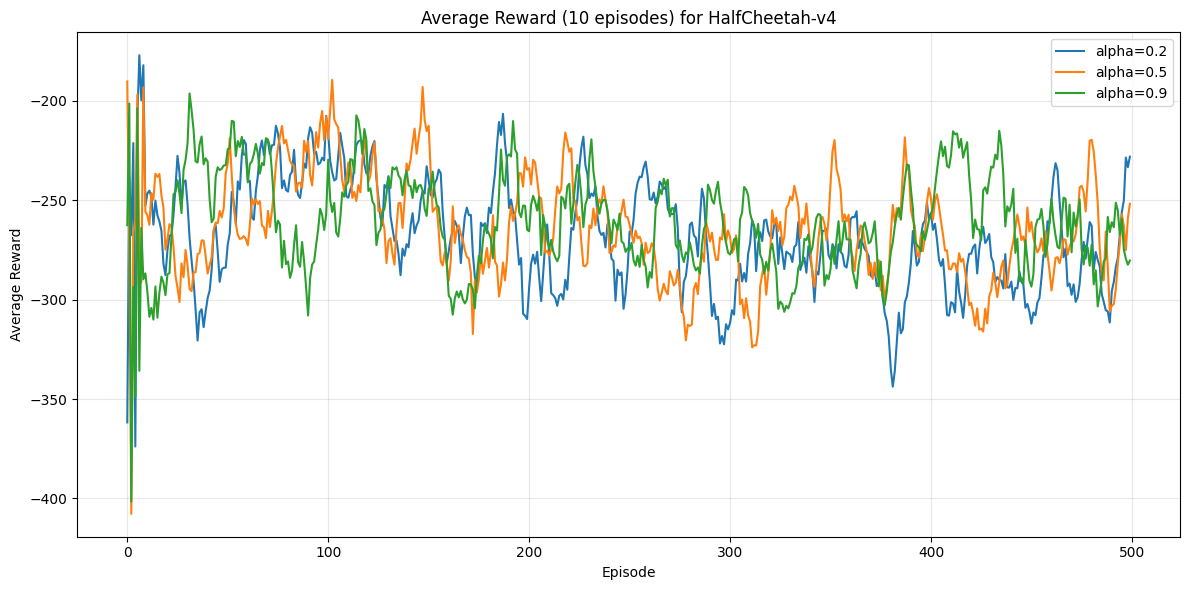


Evaluating the trained agent (alpha=0.5) over 10 episodes for HalfCheetah-v4...
Evaluation episode 1: Reward = -223.13, Steps = 1000
Evaluation video saved as evaluation_q_learning_video.mp4
Evaluation episode 2: Reward = -113.13, Steps = 1000
Evaluation episode 3: Reward = -232.92, Steps = 1000
Evaluation episode 4: Reward = -137.07, Steps = 1000
Evaluation episode 5: Reward = -205.70, Steps = 1000
Evaluation episode 6: Reward = -205.08, Steps = 1000
Evaluation episode 7: Reward = -302.78, Steps = 1000
Evaluation episode 8: Reward = -170.41, Steps = 1000
Evaluation episode 9: Reward = -101.28, Steps = 1000
Evaluation episode 10: Reward = -257.03, Steps = 1000

Evaluation complete! Average reward over 10 episodes: -194.85
Q-table final size: 60213 states

Q-Learning Statistics:
- Environment: HalfCheetah-v4
- State dimensions: 17, clipped to [-25, 25]
- Action space dimensions: 6
- Discretization bins per state dimension: 2
- Discretization bins per action dimension: 2
- Final Q-table

In [1]:
!apt-get update
!apt-get install -y xvfb python3-opengl ffmpeg libosmesa6-dev libgl1-mesa-glx libglib2.0-0 patchelf
!pip install gymnasium mujoco==2.3.3 matplotlib pyvirtualdisplay imageio imageio-ffmpeg

import os
os.environ['MUJOCO_GL'] = 'osmesa'

from pyvirtualdisplay import Display
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import math
import imageio
import imageio.v3 as iio

print("Starting virtual display...")
display = Display(visible=0, size=(1400, 900))
display.start()
time.sleep(5)

env = None
env_name = None
try:
    env = gym.make('HalfCheetah-v2', render_mode='rgb_array')
    env_name = 'HalfCheetah-v2'
    print("Successfully created HalfCheetah-v2 environment")
except:
    try:
        env = gym.make('HalfCheetah-v4', render_mode='rgb_array')
        env_name = 'HalfCheetah-v4'
        print("Successfully created HalfCheetah-v4 environment")
    except:
        try:
            env = gym.make('Ant-v4', render_mode='rgb_array')
            env_name = 'Ant-v4'
            print("HalfCheetah not available, using Ant-v4 as fallback")
        except:
            print("Ant-v4 not available, please check MuJoCo installation.")
            exit()

print(f"Environment: {env_name}")
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

action_bins = 2
state_bins = 2
action_dim = env.action_space.shape[0]
state_dim = env.observation_space.shape[0]
action_max = env.action_space.high
action_min = env.action_space.low
state_clip = 25.0

Q_table = {}

def discretize_state(state):
    """Discretize continuous state into 2 bins, clipped to [-25, 25]."""
    state = np.clip(state, -state_clip, state_clip)
    discrete_state = []
    for i in range(state_dim):
        bin_idx = int((state[i] + state_clip) / (2 * state_clip) * state_bins)
        discrete_state.append(min(bin_idx, state_bins-1))
    return tuple(discrete_state)

def discretize_action(action):
    """Discretize continuous action into 2 bins."""
    discrete_action = []
    for i in range(action_dim):
        bin_idx = int((action[i] - action_min[i]) / (action_max[i] - action_min[i]) * action_bins)
        discrete_action.append(min(bin_idx, action_bins-1))
    return tuple(discrete_action)

def get_continuous_action(discrete_action):
    """Convert discrete action to continuous action."""
    continuous_action = np.zeros(action_dim)
    for i in range(action_dim):
        bin_val = discrete_action[i]
        continuous_action[i] = action_min[i] + (bin_val + 0.5) * (action_max[i] - action_min[i]) / action_bins
    return continuous_action

def record_video(env, q_table, filename="q_learning_video.mp4", num_frames=1000):
    """Record a video of the agent acting in the environment using the Q-table."""
    frames = []
    state, _ = env.reset()
    for i in range(num_frames):
        frame = env.render()
        frames.append(frame)

        discrete_state = discretize_state(state)
        if discrete_state in q_table and q_table[discrete_state]:
            discrete_action = max(q_table[discrete_state].items(), key=lambda x: x[1])[0]
        else:
            discrete_action = tuple(random.randint(0, action_bins-1) for _ in range(action_dim))

        continuous_action = get_continuous_action(discrete_action)
        state, reward, done, truncated, _ = env.step(continuous_action)

        if done or truncated:
            state, _ = env.reset()

    iio.imwrite(filename, frames, fps=30, codec='h264')
    print(f"Video saved as {filename}")

def record_random_video(env, filename="random_action_video.mp4", num_frames=100):
    """Record a video with random actions to verify setup."""
    frames = []
    state, _ = env.reset()
    for i in range(num_frames):
        frame = env.render()
        frames.append(frame)
        action = env.action_space.sample()
        state, reward, done, truncated, _ = env.step(action)
        if done or truncated:
            state, _ = env.reset()

    iio.imwrite(filename, frames, fps=30, codec='h264')
    print(f"Random action video saved as {filename}")

print("Recording a test video with random actions...")
try:
    record_random_video(env)
    print("Test video recorded successfully!")
except Exception as e:
    print(f"Error recording test video: {e}")

def train_q_learning(env, num_episodes=500, alpha=0.5, gamma=0.99, epsilon_start=0.99):
    """Train Q-learning agent with paper-aligned parameters and video recording."""
    global Q_table
    rewards = []
    avg_rewards = []
    epsilon = epsilon_start
    start_time = time.time()

    for episode in range(num_episodes):
        state, _ = env.reset()
        discrete_state = discretize_state(state)
        total_reward = 0
        done = False
        truncated = False
        steps = 0

        while not (done or truncated) and steps < 1000:
            if random.uniform(0, 1) < epsilon:
                discrete_action = tuple(random.randint(0, action_bins-1) for _ in range(action_dim))
            else:
                if discrete_state in Q_table and Q_table[discrete_state]:
                    discrete_action = max(Q_table[discrete_state].items(),
                                       key=lambda x: x[1])[0]
                else:
                    discrete_action = tuple(random.randint(0, action_bins-1) for _ in range(action_dim))

            continuous_action = get_continuous_action(discrete_action)
            next_state, reward, done, truncated, _ = env.step(continuous_action)
            discrete_next_state = discretize_state(next_state)

            if discrete_state not in Q_table:
                Q_table[discrete_state] = {}
            if discrete_action not in Q_table[discrete_state]:
                Q_table[discrete_state][discrete_action] = 0

            next_q_max = 0
            if discrete_next_state in Q_table and Q_table[discrete_next_state]:
                next_q_max = max(Q_table[discrete_next_state].values())

            Q_table[discrete_state][discrete_action] = (
                Q_table[discrete_state][discrete_action] +
                alpha * (reward + gamma * next_q_max - Q_table[discrete_state][discrete_action])
            )

            discrete_state = discrete_next_state
            total_reward += reward
            steps += 1

            if episode == 0 and steps == 1:
                print(f"Sample discrete state: {discrete_state}")

        rewards.append(total_reward)
        avg_rewards.append(total_reward if len(rewards) < 10 else sum(rewards[-10:]) / 10)

        epsilon = math.log10((episode + 1) / 25)
        epsilon = max(0.1, min(epsilon, epsilon_start))

        if (episode + 1) % 100 == 0:
            record_video(env, Q_table, f"q_learning_video_episode_{episode + 1}.mp4")

        if (episode + 1) % 10 == 0 or episode == 0:
            elapsed = time.time() - start_time
            print(f"Episode {episode + 1}/{num_episodes}, Reward: {total_reward:.2f}, "
                  f"Avg(10): {avg_rewards[-1]:.2f}, Epsilon: {epsilon:.2f}, "
                  f"Steps: {steps}, Q-table size: {len(Q_table)}, Time: {elapsed:.1f}s")

    record_video(env, Q_table, "final_q_learning_video.mp4")
    return rewards, avg_rewards

learning_rates = [0.2, 0.5, 0.9]
all_rewards = {}
all_avg_rewards = {}

for alpha in learning_rates:
    print(f"\nStarting Q-learning training with alpha={alpha}...")
    Q_table = {}
    rewards, avg_rewards = train_q_learning(
        env,
        num_episodes=500,
        alpha=alpha,
        gamma=0.99,
        epsilon_start=0.99
    )
    all_rewards[alpha] = rewards
    all_avg_rewards[alpha] = avg_rewards

plt.figure(figsize=(12, 6))
for alpha in learning_rates:
    plt.plot(all_avg_rewards[alpha], label=f'alpha={alpha}')
plt.title(f'Average Reward (10 episodes) for {env_name}')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nEvaluating the trained agent (alpha=0.5) over 10 episodes for {env_name}...")
eval_env = gym.make(env_name, render_mode='rgb_array')
eval_rewards = []

for i in range(10):
    state, _ = eval_env.reset()
    total_reward = 0
    done = False
    truncated = False
    steps = 0

    if i == 0:
        frames = []

    while not (done or truncated) and steps < 1000:
        if i == 0:
            frame = eval_env.render()
            frames.append(frame)

        discrete_state = discretize_state(state)
        if discrete_state in Q_table and Q_table[discrete_state]:
            discrete_action = max(Q_table[discrete_state].items(), key=lambda x: x[1])[0]
        else:
            discrete_action = tuple(random.randint(0, action_bins-1) for _ in range(action_dim))

        continuous_action = get_continuous_action(discrete_action)
        state, reward, done, truncated, _ = eval_env.step(continuous_action)
        total_reward += reward
        steps += 1

    eval_rewards.append(total_reward)
    print(f"Evaluation episode {i+1}: Reward = {total_reward:.2f}, Steps = {steps}")

    if i == 0:
        iio.imwrite("evaluation_q_learning_video.mp4", frames, fps=30, codec='h264')
        print("Evaluation video saved as evaluation_q_learning_video.mp4")

print(f"\nEvaluation complete! Average reward over 10 episodes: {sum(eval_rewards) / len(eval_rewards):.2f}")
print(f"Q-table final size: {len(Q_table)} states")
eval_env.close()

print("\nQ-Learning Statistics:")
print(f"- Environment: {env_name}")
print(f"- State dimensions: {state_dim}, clipped to [-25, 25]")
print(f"- Action space dimensions: {action_dim}")
print(f"- Discretization bins per state dimension: {state_bins}")
print(f"- Discretization bins per action dimension: {action_bins}")
print(f"- Final Q-table size: {len(Q_table)} states")
print(f"- Average reward in final 10 training episodes (alpha=0.5): {all_avg_rewards[0.5][-1]:.2f}")

print("\nExample Q-table entries:")
count = 0
for state, actions in Q_table.items():
    if count >= 3:
        break
    if actions:
        best_action = max(actions.items(), key=lambda x: x[1])[0]
        best_value = actions[best_action]
        print(f"State {state}: Best action {best_action}, Value {best_value:.2f}")
        count += 1

print("Stopping virtual display...")
display.stop()